## Modules

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
 
from datetime import datetime, timedelta
from time import time
from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import yfinance as yf
from tdcalendar import *

## Data preparation

### Price data collection

In [2]:
def getYahooData(symbolList, adjust=True, startStr='1990-01-01', endStr='2046-12-31'):
    """Scrape via yahoo API to obtain data for a symbolList."""
    symbolStr = ' '.join(symbolList)
    renameDict = {'Date': 'date', 'Open': 'op', 'High': 'hi', 'Low': 'lo', 'Close': 'cl',
                  'Volume': 'vol', 'Adj Close': 'adj_cl', 'Dividends': 'div', 'Stock Splits': 'split'}
    priceFields = ['op', 'hi', 'lo', 'cl']
    dataFields = priceFields + ['vol', 'div']

    dataDict = {}

    try:
        dfData = yf.download(symbolStr, start=startStr, end=endStr, auto_adjust=False, actions=True,
                             group_by='Tickers', threads=16)
    except:
        dfData = pd.DataFrame()

    for symbol in symbolList:
        try:
            dfSymbol = dfData[(symbol,)].dropna()  # Raw data for the symbol
            dfSymbol = dfSymbol[(dfSymbol['Volume'] > 0) | (dfSymbol['High'] > dfSymbol['Low'])]  # Filter bad data
            dfSymbol.reset_index(inplace=True)
            dfSymbol.rename(columns=renameDict, inplace=True)
            dfSymbol.set_index('date', inplace=True)

            if not adjust:
                dfSymbol = dfSymbol[dataFields]
                dfSymbol.rename(columns={field: f'{symbol}_{field}' for field in dataFields}, inplace=True)
            else:
                adjfactor = dfSymbol['adj_cl'] / dfSymbol['cl']
                for field in priceFields:
                    dfSymbol[f'adj_{field}'] = dfSymbol[field] * adjfactor
                dfSymbol['adj_vol'] = dfSymbol['vol'] / adjfactor
                dfSymbol = dfSymbol[[f'adj_{field}' for field in dataFields[:-1]]]
                dfSymbol.rename(columns={f'adj_{field}': f'{symbol}_{field}' for field in dataFields[:-1]}, inplace=True)
                dfSymbol = np.round(dfSymbol, 4)

            dataDict[symbol] = dfSymbol
        except:
            print(f'Failed preparing data for {symbol}.')

    dfAll = pd.concat(dataDict.values(), axis=1, join='inner')
    dfAll.fillna(method='ffill', inplace=True)

    return dfAll

In [3]:
symbolList = ['SPY', 'QQQ', 'IWM', 'EWH', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'BRK-B', 'BA']

startStr = '2011-01-01'
endStr = '2023-01-01'
dfAll = getYahooData(symbolList, True, startStr, endStr)

[*********************100%***********************]  10 of 10 completed


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
D:\Anaconda\lib\site-p

### Dictionary of dataframes of open, close & log-change columns in training period

In [4]:
startStr_train1 = '2019-07-01'
endStr_train1 = '2022-07-01'
startDate_train1 = datetime.strptime(startStr_train1, '%Y-%m-%d')
endDate_train1 = datetime.strptime(endStr_train1, '%Y-%m-%d')

startStr_test1 = getLatestTradingDay(holidayList_ny, endDate_train1, days=0, offset=0)
endStr_test1 = '2022-12-31'
startDate_test1 = datetime.strptime(startStr_test1, '%Y-%m-%d')
endDate_test1 = datetime.strptime(endStr_test1, '%Y-%m-%d')
tradeDateList_test1 = getTradingDays(holidayList_ny, startDate_test1, endDate_test1)

dataDict_train1 = {}
dataDict_test1 = {}

for symbol in symbolList:
    dfSymbol = dfAll[[f'{symbol}_op', f'{symbol}_cl']]
    dfSymbol[f'{symbol}_pct'] = np.log(dfSymbol[f'{symbol}_cl'] / dfSymbol[f'{symbol}_cl'].shift(1))
    dataDict_train1[symbol] = dfSymbol.loc[startStr_train1:endStr_train1]
    dataDict_test1[symbol] = dfSymbol.loc[startStr_test1:endStr_test1]
    
print(dataDict_train1['NVDA'].tail(10), '\n')

<ipython-input-4-e97c67633ca6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSymbol[f'{symbol}_pct'] = np.log(dfSymbol[f'{symbol}_cl'] / dfSymbol[f'{symbol}_cl'].shift(1))


             NVDA_op   NVDA_cl  NVDA_pct
date                                    
2022-06-17  156.3669  158.6853  0.017726
2022-06-21  164.6310  165.5403  0.042292
2022-06-22  162.1428  163.4818 -0.012513
2022-06-23  165.0706  162.1328 -0.008286
2022-06-24  164.8808  171.1363  0.054045
2022-06-27  172.9949  168.5681 -0.015120
2022-06-28  168.8779  159.7045 -0.054015
2022-06-29  158.0257  155.3077 -0.027917
2022-06-30  153.4990  151.4805 -0.024951
2022-07-01  148.8824  145.1251 -0.042861 



## Monte-Carlo Resampling (MCR)

### Construction of (1x leverage) forward time series by MCR

In [5]:
def getSim_mcr1x(dfData, dateList, startPrice=1.00, numSim=100, numDigit=4):
    """Obtain the dataframe of MCR simulations of forward price time-series."""
    # Build MCR dataframe by dummy zero-return price time-series
    dfSim = pd.DataFrame()
    for date in dateList:
        dfSim.loc[date, f'pct-0'] = 0
        dfSim.loc[date, f'cl-0'] = startPrice
    # Historical return array     
    pctArray = np.array(dfData[f'{symbol}_pct'])
    numData = len(pctArray)
    # MCR simulations
    lenPeriod = len(dateList) - 1
    for num in range(numSim):
        ordinalArray = np.random.randint(numData, size=lenPeriod)
        fwdPctArray = [0] + [pctArray[n] for n in ordinalArray]
        dfSim[f'pct-{num + 1}'] = fwdPctArray
        dfSim[f'cl-{num + 1}'] = np.round(startPrice * np.exp(dfSim[f'pct-{num + 1}'].cumsum()), numDigit)
    
    return dfSim        

def fitActualvsMCR(dfSim, dfData, dateList):
    """Fit the actual price time-series into an MCR dataframe."""
    dfSim['cl-0'] = dfData.loc[dateList, f'{symbol}_cl']
    dfSim['pct-0'] = dfData.loc[dateList, f'{symbol}_pct']
    
    return dfSim

### MCR using real stock price as starting price and its normalized copy (`startPrice = 1.00`)

In [6]:
numSim = 400

# Empty dict of MCR using real stock price as starting price
fwdDict = {}  
# `fwdDict` with each stock price normalized 
normDict = {}

# Construction of `fwdDict`
for symbol in symbolList:
    dfData_train = dataDict_train1[symbol]
    dfData_test = dataDict_test1[symbol]
    startPrice = dfData_train[f'{symbol}_cl'].iloc[-1]
    # MCR simulations (using last price in training period as )
    dfSim = getSim_mcr1x(dfData_train, tradeDateList_test1, startPrice, numSim) 
    # Concat with actual price data set (Do NOT do this with genuine future timestamps where no price data is available)
    dfSim =  fitActualvsMCR(dfSim, dfData_test, tradeDateList_test1)
    print(f'{symbol} MCR done.')
    # Normalize the MCR dataframe
    dfNorm = dfSim.copy()
    for n in range(numSim + 1):
        dfNorm[f'cl-{n}'] /= startPrice
    # Save to dict
    fwdDict[symbol] = dfSim
    normDict[symbol] = np.round(dfNorm, 6)
    
fwdDict['NVDA'].iloc[-5:, :12]

SPY MCR done.
QQQ MCR done.
IWM MCR done.
EWH MCR done.
AAPL MCR done.
MSFT MCR done.
NVDA MCR done.
TSLA MCR done.
BRK-B MCR done.
BA MCR done.


pct-0      cl-0     pct-1      cl-1     pct-2      cl-2  \
2022-12-23 -0.008709  152.0342  0.006565  175.2921  0.031851  179.8727   
2022-12-27 -0.074027  141.1860  0.031795  180.9550  0.012447  182.1256   
2022-12-28 -0.006037  140.3362  0.031114  186.6738  0.025635  186.8548   
2022-12-29  0.039601  146.0052  0.038302  193.9624 -0.025432  182.1627   
2022-12-30  0.000753  146.1152  0.069588  207.9405 -0.015589  179.3449   

               pct-3      cl-3     pct-4      cl-4     pct-5      cl-5  
2022-12-23  0.000485  225.4506  0.000070  171.7543 -0.014390  132.6086  
2022-12-27 -0.014355  222.2374 -0.010820  169.9059 -0.096917  120.3597  
2022-12-28 -0.032228  215.1893 -0.070450  158.3479  0.001405  120.5290  
2022-12-29 -0.054015  203.8743  0.018361  161.2821 -0.009010  119.4479  
2022-12-30  0.008987  205.7147  0.023963  165.1935 -0.018708  117.2340

In [7]:
normDict['NVDA'].iloc[-5:, :12]

pct-0      cl-0     pct-1      cl-1     pct-2      cl-2  \
2022-12-23 -0.008709  1.047608  0.006565  1.207869  0.031851  1.239432   
2022-12-27 -0.074027  0.972857  0.031795  1.246890  0.012447  1.254956   
2022-12-28 -0.006037  0.967002  0.031114  1.286296  0.025635  1.287543   
2022-12-29  0.039601  1.006064  0.038302  1.336519 -0.025432  1.255212   
2022-12-30  0.000753  1.006822  0.069588  1.432836 -0.015589  1.235795   

               pct-3      cl-3     pct-4      cl-4     pct-5      cl-5  
2022-12-23  0.000485  1.553491  0.000070  1.183491 -0.014390  0.913754  
2022-12-27 -0.014355  1.531351 -0.010820  1.170755 -0.096917  0.829351  
2022-12-28 -0.032228  1.482785 -0.070450  1.091113  0.001405  0.830518  
2022-12-29 -0.054015  1.404818  0.018361  1.111332 -0.009010  0.823069  
2022-12-30  0.008987  1.417499  0.023963  1.138283 -0.018708  0.807813

### Compute percentile of final price of each MCR time series

In [8]:
def getRank_finalPrice(dfSim):
    """Obtain the percentage rank of final price of each MCR time series. """
    numSim = dfSim.shape[1] // 2 - 1
    dfRank = dfSim[[f'cl-{n + 1}' for n in range(numSim)]]
    dfRank.loc['rank'] = np.round(dfRank.iloc[-1].rank(pct=True), 4)
    dfRank = dfRank.transpose()
    
    return dfRank

rankDict = {symbol: getRank_finalPrice(dfSim) for symbol, dfSim in normDict.items()}
rankDict['NVDA'].iloc[:10, -2:]

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


2022-12-30    rank
cl-1     1.432836  0.6550
cl-2     1.235795  0.4800
cl-3     1.417499  0.6500
cl-4     1.138283  0.3850
cl-5     0.807813  0.1350
cl-6     1.856425  0.8775
cl-7     1.313281  0.5725
cl-8     1.765034  0.8325
cl-9     1.395032  0.6375
cl-10    0.889189  0.1975

### Descriptive Statistics of the simulated log-return groups

In [9]:
dfStat_mcr = pd.DataFrame()
numSim = 400

for symbol, df in fwdDict.items():
    dfPrice_mcr = np.log(df[[f'cl-{n + 1}' for n in range(numSim)]] / df['cl-0'].iloc[0])
    dfFinal_mcr = dfPrice_mcr.iloc[[-1]].transpose()
    dfStat_mcr[symbol] = dfFinal_mcr.describe().iloc[:, 0]
    
dfStat_mcr

SPY         QQQ         IWM         EWH        AAPL        MSFT  \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.043030    0.080841    0.024768   -0.014088    0.187234    0.091034   
std      0.160733    0.208111    0.212513    0.159031    0.241156    0.240378   
min     -0.452610   -0.530989   -0.761688   -0.487306   -0.446885   -0.735028   
25%     -0.070435   -0.061028   -0.106267   -0.116309    0.012591   -0.065631   
50%      0.049726    0.071726    0.042211   -0.017575    0.187002    0.081321   
75%      0.150825    0.210901    0.156668    0.092127    0.355541    0.245349   
max      0.485842    0.779742    0.557812    0.435400    0.842623    0.980620   

             NVDA        TSLA       BRK-B          BA  
count  400.000000  400.000000  400.000000  400.000000  
mean     0.217665    0.483412    0.044085   -0.138086  
std      0.390013    0.461018    0.161015    0.414942  
min     -1.141349   -0.971717   -0.401030   -1.240776  
25%     -0.048585    0.181046   -0.064173   -0.424305  
50%      0.223629    0.492021    0.043603   -0.135212  
75%      0.470658    0.792342    0.164595    0.138006  
max      1.276235    1.823225    0.529974    0.970502

### Visualize the simulated equity curves, the actual curve

In [10]:
pctileDict = {0.95: '#09752d', 0.50: '#115bef', 0.05:'#ef1139'}


def plotMCRcurves(dfSim, plotPctiles, titletext, actual=True, boldWidth=4):
    """Plot all the simulated equity curve from the same MCR together with the actual price curve (`actual` = True)."""
    # Forward price dataframe
    dfPrice = dfSim[[f'cl-{n}' for n in range(numSim + 1)]] if actual else dfSim[[f'cl-{n + 1}' for n in range(numSim)]]
    startDT = dfPrice.index[0]
    endDT = dfPrice.index[-1]
    # Plot figure & append title
    fig, ax = plt.subplots(figsize=(12, 9))
    title = f'MCR from {startDT} to {endDT} {titletext} \n'
    # Plot the resultant MCR curves
    plt.semilogy(dfPrice, linewidth=1)
    
    # For the chosen percentile, find out the corresponding final price level and bolden the curve
    for pctile, color in plotPctiles.items():
        dfRank = getRank_finalPrice(dfSim)
        rankLevel = 0
        while rankLevel / numSim < pctile:
            rankLevel += 1
        seriesName = dfRank[dfRank['rank'] == pctile].index[0] 
        finalPrice = round(dfPrice[seriesName].iloc[-1], 4)
        title += f'{round(100 * pctile, 2)}%ile = {finalPrice}, '
        plt.semilogy(dfPrice.index, dfPrice[seriesName], linewidth=boldWidth, color=color)
        
    # Bolden the special percentile equity curve
    if actual:
        plt.semilogy(dfPrice.index, dfPrice['cl-0'], color='black', linewidth=boldWidth)
        dfRank.sort_values('rank', inplace=True)
        finalPriceArray = np.array(dfRank.iloc[:, -2])
        lastPrice = dfPrice.loc[endDT, 'cl-0']
        rankActual = 0
        while lastPrice >= finalPriceArray[rankActual]:
            rankActual += 1
        pctileActual = round(100 * rankActual / numSim, 2)
        title += f'\nActual final price {lastPrice} = {pctileActual}%ile'    
            
    fig.suptitle(title, fontsize=12)   
    ax.tick_params(labelbottom=False)  

### MCR curve of normed price (w/o actual price curve)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

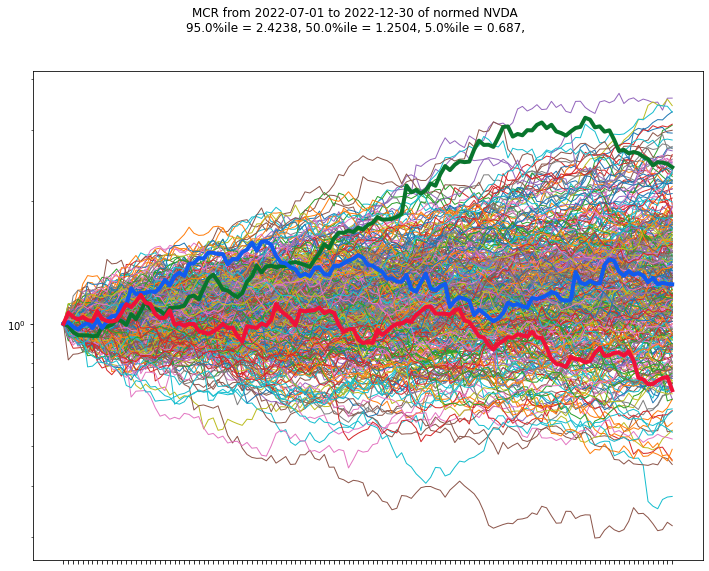

In [11]:
symbol1 = 'NVDA'
plotMCRcurves(normDict[symbol1], pctileDict, actual=False, titletext=f'of normed {symbol1}')

### MCR curve chart together with actual price curve

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

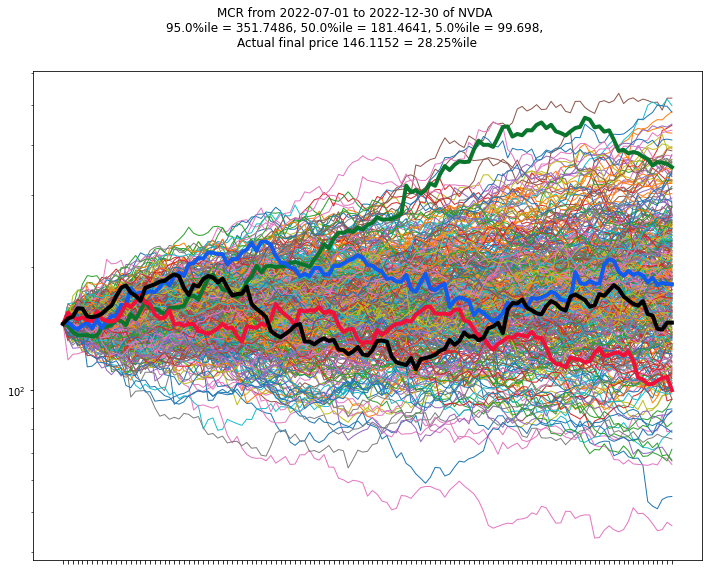

In [12]:
plotMCRcurves(fwdDict[symbol1], pctileDict, titletext=f'of {symbol1}')

### MCR curve chart with actual price being normed

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

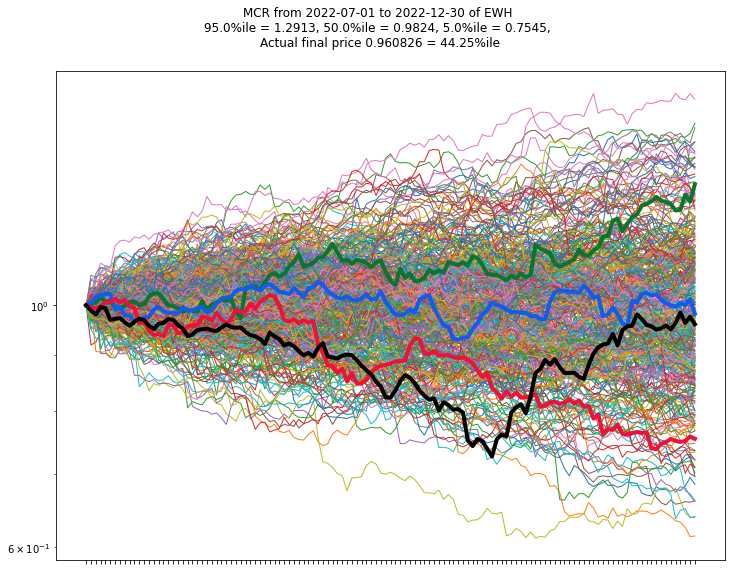

In [13]:
symbol2 = 'EWH'
plotMCRcurves(normDict[symbol2], pctileDict, titletext=f'of {symbol2}')

### An example of actual final price outside the MCR confidence interval

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

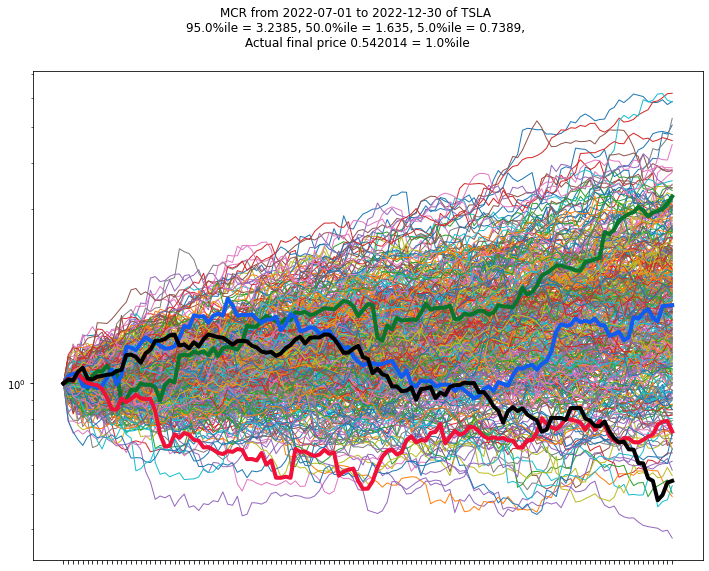

In [14]:
symbol3 = 'TSLA'
plotMCRcurves(normDict[symbol3], pctileDict, titletext=f'of {symbol3}')

### Compute expected percentage return drawn from the middle 90% MCR curves

In [15]:
# Dataframe of key statistics
dfExpNAV = pd.DataFrame()

# Dataframe of mid 90% MCR final price
dfFinal = pd.DataFrame()

# Percentile levels
maxPctile = 0.95
midPctile = 0.50
minPctile = 0.05

for (symbol, dfRank), (symbol, dfNorm) in zip(rankDict.items(), normDict.items()):
    # For each symbol, extract the mid 90% final price column
    dfMid = dfRank[(dfRank['rank'] >= minPctile) & (dfRank['rank'] <= maxPctile)]
    dfFinal0 = dfMid.iloc[:, -2:]
    dfFinal0.sort_values('rank', inplace=True)
    dfFinal0.reset_index(inplace=True)
    dfFinal0.drop(['index', 'rank'], axis=1, inplace=True)
    dfFinal0.rename(columns={dfFinal0.columns[0]: symbol}, inplace=True)
    dfFinal = pd.concat([dfFinal, dfFinal0], axis=1)
    # Record the percentile level final price
    dfExpNAV.loc[symbol, f'{round(100*maxPctile, 1)}%ile'] = dfFinal[symbol].max()
    dfExpNAV.loc[symbol, f'{round(100*midPctile, 1)}%ile'] = dfFinal[symbol].median()
    dfExpNAV.loc[symbol, f'{round(100*minPctile, 1)}%ile'] = dfFinal[symbol].min()
    # Average P/L of final prices
    dfExpNAV.loc[symbol, 'avg%PL'] = round(dfFinal[symbol].mean() - 1, 4)
    dfExpNAV.loc[symbol, 'real%PL'] = round(dfNorm['cl-0'].iloc[-1] - 1, 4)

<ipython-input-15-8e3f8d27cf65>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFinal0.sort_values('rank', inplace=True)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
D:\Anaconda\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-15-8e3f8d27cf65>:16: SettingWithCopyWarning: 
A v

In [16]:
dfExpNAV

95.0%ile  50.0%ile   5.0%ile  avg%PL  real%PL
SPY    1.355362  1.050335  0.811893  0.0516   0.0119
QQQ    1.517955  1.074250  0.780841  0.0952  -0.0522
IWM    1.481421  1.042516  0.714760  0.0396   0.0272
EWH    1.291257  0.982361  0.754498 -0.0063  -0.0392
AAPL   1.823238  1.205316  0.820193  0.2262  -0.0619
MSFT   1.662323  1.084549  0.728754  0.1126  -0.0716
NVDA   2.423761  1.250398  0.686980  0.2987   0.0068
TSLA   3.238494  1.634976  0.738894  0.7285  -0.4580
BRK-B  1.342337  1.042613  0.796732  0.0543   0.1132
BA     1.723597  0.873083  0.435981 -0.0814   0.3622

In [17]:
dfFinal

SPY       QQQ       IWM       EWH      AAPL      MSFT      NVDA  \
0    0.811893  0.780841  0.714760  0.754498  0.820193  0.728754  0.686980   
1    0.813383  0.786050  0.720193  0.767143  0.822073  0.736243  0.690646   
2    0.813552  0.790035  0.720781  0.767687  0.822371  0.740106  0.691881   
3    0.813558  0.791651  0.723283  0.775379  0.823945  0.740718  0.692050   
4    0.814147  0.791960  0.723718  0.778434  0.824191  0.742012  0.693928   
..        ...       ...       ...       ...       ...       ...       ...   
356  1.345205  1.504595  1.444209  1.265821  1.785334  1.591176  2.347045   
357  1.345285  1.505807  1.454913  1.268030  1.793679  1.596858  2.366259   
358  1.347625  1.509163  1.455866  1.273527  1.801335  1.599888  2.376558   
359  1.354579  1.516027  1.462245  1.275919  1.804843  1.657501  2.381916   
360  1.355362  1.517955  1.481421  1.291257  1.823238  1.662323  2.423761   

         TSLA     BRK-B        BA  
0    0.738894  0.796732  0.435981  
1    0.748148  0.800716  0.437002  
2    0.750673  0.805606  0.437592  
3    0.771516  0.805641  0.438987  
4    0.773225  0.813631  0.439858  
..        ...       ...       ...  
356  3.150245  1.323507  1.694617  
357  3.152307  1.325227  1.699155  
358  3.174479  1.331124  1.703020  
359  3.191580  1.338821  1.711231  
360  3.238494  1.342337  1.723597  

[361 rows x 10 columns]

### Visualize by box plot

In [18]:
fig = make_subplots(rows=1, cols=1, specs=[[{"type": "box"}]])

for symbol in symbolList:
    fig.add_trace(go.Box(y=dfFinal[symbol], name=symbol), row=1, col=1)
    
fig.update_yaxes(type="log")
fig.show()

## Another example of MCR with test period rolling to future

### Training set data

In [ ]:
startStr_train2 = '2021-12-20'
endStr_train2 = '2023-03-17'
startDate_train2 = datetime.strptime(startStr_train2, '%Y-%m-%d')
endDate_train2 = datetime.strptime(endStr_train2, '%Y-%m-%d')

startStr_test2 = getLatestTradingDay(holidayList_ny, endDate_train2, days=0, offset=0)
endStr_test2 = '2023-06-30'
startDate_test2 = datetime.strptime(startStr_test2, '%Y-%m-%d')
endDate_test2 = datetime.strptime(endStr_test2, '%Y-%m-%d')
tradeDateList_test2 = getTradingDays(holidayList_ny, startDate_test2, endDate_test2)

dataDict_train2 = {}

for symbol in symbolList:
    dfSymbol = dfAll[[f'{symbol}_op', f'{symbol}_cl']]
    dfSymbol[f'{symbol}_pct'] = np.log(dfSymbol[f'{symbol}_cl'] / dfSymbol[f'{symbol}_cl'].shift(1))
    dataDict_train2[symbol] = dfSymbol.loc[startStr_train2:endStr_train2]

### MCR on testing set

In [ ]:
# Empty dict of MCR using real stock price as starting price
fwdDict2 = {}  

# `fwdDict` with each stock price normalized 
normDict2 = {}

# Construction of `fwdDict`
for symbol in symbolList:
    dfData_train = dataDict_train2[symbol]
    dfData_test = dataDict_test2[symbol]
    startPrice = dfData_train[f'{symbol}_cl'].iloc[-1]
    # MCR simulations (using last price in training period as )
    dfSim = getSim_mcr1x(dfData_train, tradeDateList_test2, startPrice, numSim) 
    print(f'{symbol} MCR done.')
    # Normalize the MCR dataframe
    dfNorm = dfSim.copy()
    for n in range(numSim):
        dfNorm[f'cl-{n + 1}'] /= startPrice
    # Save to dict
    fwdDict2[symbol] = dfSim
    normDict2[symbol] = np.round(dfNorm, 6)

In [ ]:
rankDict2 = {symbol: getRank_finalPrice(dfSim) for symbol, dfSim in normDict2.items()}